In [283]:
import numpy as np 
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn import preprocessing

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge,Lasso

In [4]:
data_frames = {}
for dirname, _, filenames in os.walk('Data2022\MDataFiles_Stage1\.'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        data_frames[filename[:-4]] = pd.read_csv(os.path.join(dirname, filename),encoding = 'ISO-8859-1')

In [5]:
data_frames.keys()

dict_keys(['Cities', 'Conferences', 'MConferenceTourneyGames', 'MGameCities', 'MMasseyOrdinals', 'MNCAATourneyCompactResults', 'MNCAATourneyDetailedResults', 'MNCAATourneySeedRoundSlots', 'MNCAATourneySeeds', 'MNCAATourneySlots', 'MRegularSeasonCompactResults', 'MRegularSeasonDetailedResults', 'MSampleSubmissionStage1', 'MSeasons', 'MSecondaryTourneyCompactResults', 'MSecondaryTourneyTeams', 'MTeamCoaches', 'MTeamConferences', 'MTeams', 'MTeamSpellings'])

In [151]:
MTeams = pd.DataFrame(data_frames['MTeams'].copy())
MTeams[MTeams['TeamName'] == 'Gonzaga']

,TeamID,TeamName,FirstD1Season,LastD1Season
110,1211,Gonzaga,1985,2022


In [13]:
MRegularSeasonDetailedResults = pd.DataFrame(data_frames['MRegularSeasonDetailedResults'].copy())
MRegularSeasonDetailedResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76,H,0,28,67,...,13,15,23,5,24,10,15,3,5,21
100419,2022,98,1411,66,1126,63,A,0,24,59,...,21,15,24,5,23,10,19,13,2,23
100420,2022,98,1422,68,1441,49,A,0,23,56,...,24,8,11,10,18,5,16,8,2,12
100421,2022,98,1438,69,1181,68,A,0,31,65,...,17,18,22,11,25,14,14,3,9,11


In [12]:
MRegularSeasonCompactResults = pd.DataFrame(data_frames['MRegularSeasonCompactResults'].copy())
MRegularSeasonCompactResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
174466,2022,98,1400,79,1242,76,H,0
174467,2022,98,1411,66,1126,63,A,0
174468,2022,98,1422,68,1441,49,A,0
174469,2022,98,1438,69,1181,68,A,0


In [100]:
winning_dataset = pd.DataFrame(data_frames['MRegularSeasonCompactResults'].copy())

winning_dataset = winning_dataset[['Season', 'DayNum', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 'LTeamID', 'LScore']]
winning_dataset.columns = ['Season', 'DayNum', 'TeamID', 'Score', 'Loc','NumOT', 'OTeamID', 'OScore']

winning_dataset['Win'] = 1
winning_dataset['Loss'] = 0
winning_dataset

,Season,DayNum,TeamID,Score,Loc,NumOT,OTeamID,OScore,Win,Loss
0,1985,20,1228,81,N,0,1328,64,1,0
1,1985,25,1106,77,H,0,1354,70,1,0
2,1985,25,1112,63,H,0,1223,56,1,0
3,1985,25,1165,70,H,0,1432,54,1,0
4,1985,25,1192,86,H,0,1447,74,1,0
...,...,...,...,...,...,...,...,...,...,...
174466,2022,98,1400,79,H,0,1242,76,1,0
174467,2022,98,1411,66,A,0,1126,63,1,0
174468,2022,98,1422,68,A,0,1441,49,1,0
174469,2022,98,1438,69,A,0,1181,68,1,0


In [102]:
losing_dataset = pd.DataFrame(data_frames['MRegularSeasonCompactResults'].copy())

losing_dataset.loc[losing_dataset['WLoc'] == 'H', 'Loc'] = 'A'
losing_dataset.loc[losing_dataset['WLoc'] == 'N', 'Loc'] = 'N'
losing_dataset.loc[losing_dataset['WLoc'] == 'A', 'Loc'] = 'H'

losing_dataset = losing_dataset[['Season', 'DayNum', 'LTeamID', 'LScore', 'Loc','NumOT', 'WTeamID', 'WScore']]
losing_dataset.columns = ['Season', 'DayNum', 'TeamID', 'Score', 'Loc', 'NumOT', 'OTeamID', 'OScore']

losing_dataset['Win'] = 0
losing_dataset['Loss'] = 1
losing_dataset

,Season,DayNum,TeamID,Score,Loc,NumOT,OTeamID,OScore,Win,Loss
0,1985,20,1328,64,N,0,1228,81,0,1
1,1985,25,1354,70,A,0,1106,77,0,1
2,1985,25,1223,56,A,0,1112,63,0,1
3,1985,25,1432,54,A,0,1165,70,0,1
4,1985,25,1447,74,A,0,1192,86,0,1
...,...,...,...,...,...,...,...,...,...,...
174466,2022,98,1242,76,A,0,1400,79,0,1
174467,2022,98,1126,63,H,0,1411,66,0,1
174468,2022,98,1441,49,H,0,1422,68,0,1
174469,2022,98,1181,68,H,0,1438,69,0,1


In [103]:
AllSeasonResults = pd.concat([winning_dataset, losing_dataset], ignore_index=True)
AllSeasonResults.head()

,Season,DayNum,TeamID,Score,Loc,NumOT,OTeamID,OScore,Win,Loss
0,1985,20,1228,81,N,0,1328,64,1,0
1,1985,25,1106,77,H,0,1354,70,1,0
2,1985,25,1112,63,H,0,1223,56,1,0
3,1985,25,1165,70,H,0,1432,54,1,0
4,1985,25,1192,86,H,0,1447,74,1,0


In [112]:
seasonGroups = (AllSeasonResults
               .groupby(['Season','TeamID'])
               )
                
    

seasonAve = (seasonGroups[['Score','OScore','Win', 'NumOT']]
             .mean()
             .rename({'Win':'WinPCT'},axis=1)
             .reset_index()
             )
seasonAve.round(1)

,Season,TeamID,Score,OScore,WinPCT,NumOT
0,1985,1102,63.1,68.9,0.2,0.0
1,1985,1103,61.0,64.1,0.4,0.0
2,1985,1104,68.5,60.7,0.7,0.0
3,1985,1106,71.6,75.4,0.4,0.0
4,1985,1108,83.0,75.0,0.8,0.0
...,...,...,...,...,...,...
12294,2022,1468,66.6,70.9,0.4,0.0
12295,2022,1469,69.5,77.5,0.4,0.0
12296,2022,1470,63.4,66.5,0.4,0.0
12297,2022,1471,67.1,71.1,0.4,0.0


In [114]:
seasonTotal = (seasonGroups[['Score','OScore','Win','Loss', 'NumOT']]
             .sum()
             .reset_index()
             )
seasonTotal.round(1)

,Season,TeamID,Score,OScore,Win,Loss,NumOT
0,1985,1102,1514,1653,5,19,0
1,1985,1103,1404,1474,9,14,0
2,1985,1104,2055,1821,21,9,1
3,1985,1106,1719,1810,10,14,0
4,1985,1108,2075,1876,19,6,0
...,...,...,...,...,...,...,...
12294,2022,1468,1332,1418,9,11,1
12295,2022,1469,1321,1473,7,12,0
12296,2022,1470,1332,1396,8,13,1
12297,2022,1471,1342,1422,8,12,1


In [173]:
seasonResult = pd.merge(seasonTotal, seasonAve, how = 'left', on=['Season', 'TeamID'], suffixes=['_Total', '_Avg'])
seasonResult

,Season,TeamID,Score_Total,OScore_Total,Win,Loss,NumOT_Total,Score_Avg,OScore_Avg,WinPCT,NumOT_Avg
0,1985,1102,1514,1653,5,19,0,63.083333,68.875000,0.208333,0.000000
1,1985,1103,1404,1474,9,14,0,61.043478,64.086957,0.391304,0.000000
2,1985,1104,2055,1821,21,9,1,68.500000,60.700000,0.700000,0.033333
3,1985,1106,1719,1810,10,14,0,71.625000,75.416667,0.416667,0.000000
4,1985,1108,2075,1876,19,6,0,83.000000,75.040000,0.760000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
12294,2022,1468,1332,1418,9,11,1,66.600000,70.900000,0.450000,0.050000
12295,2022,1469,1321,1473,7,12,0,69.526316,77.526316,0.368421,0.000000
12296,2022,1470,1332,1396,8,13,1,63.428571,66.476190,0.380952,0.047619
12297,2022,1471,1342,1422,8,12,1,67.100000,71.100000,0.400000,0.050000


In [174]:
AllSeasonResults_Opponents = pd.merge(AllSeasonResults, seasonResult, how = 'left', left_on=['Season', 'OTeamID'],right_on=['Season', 'TeamID'], suffixes = ['', '_Opp'])
AllSeasonResults_Opponents

,Season,DayNum,TeamID,Score,Loc,NumOT,OTeamID,OScore,Win,Loss,TeamID_Opp,Score_Total,OScore_Total,Win_Opp,Loss_Opp,NumOT_Total,Score_Avg,OScore_Avg,WinPCT,NumOT_Avg
0,1985,20,1228,81,N,0,1328,64,1,0,1328,2695,2296,25,5,0,89.833333,76.533333,0.833333,0.000000
1,1985,25,1106,77,H,0,1354,70,1,0,1354,1637,1723,9,15,0,68.208333,71.791667,0.375000,0.000000
2,1985,25,1112,63,H,0,1223,56,1,0,1223,1708,1593,17,8,0,68.320000,63.720000,0.680000,0.000000
3,1985,25,1165,70,H,0,1432,54,1,0,1432,1460,1446,11,12,0,63.478261,62.869565,0.478261,0.000000
4,1985,25,1192,86,H,0,1447,74,1,0,1447,1760,1872,8,16,0,73.333333,78.000000,0.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348937,2022,98,1242,76,A,0,1400,79,0,1,1400,1648,1339,18,6,0,68.666667,55.791667,0.750000,0.000000
348938,2022,98,1126,63,H,0,1411,66,0,1,1411,1357,1319,10,10,1,67.850000,65.950000,0.500000,0.050000
348939,2022,98,1441,49,H,0,1422,68,0,1,1422,1457,1480,13,10,3,63.347826,64.347826,0.565217,0.130435
348940,2022,98,1181,68,H,0,1438,69,0,1,1438,1523,1437,15,9,0,63.458333,59.875000,0.625000,0.000000


In [175]:
seasonGroupsOpp = (AllSeasonResults_Opponents
               .groupby(['Season','TeamID'])
               )
                
    

seasonAveOpp = (seasonGroupsOpp[['Score_Avg','OScore_Avg','WinPCT']]
             .mean()
             .rename({'Score_Avg':'Score_Avg_Opp','OScore_Avg':'OScore_Avg_Opp','WinPCT':'WinPCT_Opp'},axis=1)
             .reset_index()
             )
seasonAveOpp.round(1)

,Season,TeamID,Score_Avg_Opp,OScore_Avg_Opp,WinPCT_Opp
0,1985,1102,69.6,70.0,0.5
1,1985,1103,67.7,69.2,0.5
2,1985,1104,69.3,68.2,0.5
3,1985,1106,72.3,72.8,0.5
4,1985,1108,72.1,73.7,0.4
...,...,...,...,...,...
12294,2022,1468,72.0,70.6,0.5
12295,2022,1469,71.0,70.9,0.5
12296,2022,1470,70.5,69.3,0.5
12297,2022,1471,66.1,68.3,0.4


In [176]:
AllSeasonResults_Opponents_Opponents = pd.merge(AllSeasonResults, seasonAveOpp, how = 'left', left_on=['Season', 'OTeamID'],right_on=['Season', 'TeamID'], suffixes = ['', '_Opp_Opp'])
AllSeasonResults_Opponents_Opponents

,Season,DayNum,TeamID,Score,Loc,NumOT,OTeamID,OScore,Win,Loss,TeamID_Opp_Opp,Score_Avg_Opp,OScore_Avg_Opp,WinPCT_Opp
0,1985,20,1228,81,N,0,1328,64,1,0,1328,71.811551,69.992737,0.544380
1,1985,25,1106,77,H,0,1354,70,1,0,1354,69.668114,72.816578,0.461520
2,1985,25,1112,63,H,0,1223,56,1,0,1223,70.121583,71.047382,0.456904
3,1985,25,1165,70,H,0,1432,54,1,0,1432,67.388056,68.383383,0.475624
4,1985,25,1192,86,H,0,1447,74,1,0,1447,68.684508,70.765520,0.420950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348937,2022,98,1242,76,A,0,1400,79,0,1,1400,70.131206,68.469085,0.525701
348938,2022,98,1126,63,H,0,1411,66,0,1,1411,67.139114,71.173869,0.416437
348939,2022,98,1441,49,H,0,1422,68,0,1,1422,71.589956,71.206226,0.499736
348940,2022,98,1181,68,H,0,1438,69,0,1,1438,71.211492,69.134575,0.532101


In [177]:
seasonGroupsOppOpp = (AllSeasonResults_Opponents_Opponents
               .groupby(['Season','TeamID'])
               )
                
    

seasonAveOppOpp = (seasonGroupsOppOpp[['Score_Avg_Opp','OScore_Avg_Opp','WinPCT_Opp']]
             .mean()
             .rename({'Score_Avg_Opp':'Score_Avg_Opp_Opp','OScore_Avg_Opp':'OScore_Avg_Opp_Opp','WinPCT_Opp':'WinPCT_Opp_Opp'},axis=1)
             .reset_index()
             )
seasonAveOppOpp.round(1)

,Season,TeamID,Score_Avg_Opp_Opp,OScore_Avg_Opp_Opp,WinPCT_Opp_Opp
0,1985,1102,69.7,69.7,0.5
1,1985,1103,67.7,68.6,0.5
2,1985,1104,69.6,68.0,0.5
3,1985,1106,71.1,72.4,0.5
4,1985,1108,71.8,72.3,0.5
...,...,...,...,...,...
12294,2022,1468,70.2,70.8,0.5
12295,2022,1469,69.8,70.8,0.5
12296,2022,1470,69.8,69.7,0.5
12297,2022,1471,68.4,69.3,0.5


In [136]:
seasonAveOpp

,Season,TeamID,Score_Avg_Opp,OScore_Avg_Opp,WinPCT_Opp
0,1985,1102,69.649112,69.974063,0.500130
1,1985,1103,67.714376,69.224447,0.474244
2,1985,1104,69.291502,68.200001,0.526081
3,1985,1106,72.319800,72.826231,0.462600
4,1985,1108,72.115634,73.697221,0.439307
...,...,...,...,...,...
12294,2022,1468,72.008396,70.580067,0.534183
12295,2022,1469,70.997143,70.877798,0.500201
12296,2022,1470,70.452105,69.311150,0.535383
12297,2022,1471,66.060983,68.275485,0.429621


In [137]:
seasonResult

,Season,TeamID,Score_Total,OScore_Total,Win,Loss,NumOT_Total,Score_Avg,OScore_Avg,WinPCT,NumOT_Avg
0,1985,1102,1514,1653,5,19,0,63.083333,68.875000,0.208333,0.000000
1,1985,1103,1404,1474,9,14,0,61.043478,64.086957,0.391304,0.000000
2,1985,1104,2055,1821,21,9,1,68.500000,60.700000,0.700000,0.033333
3,1985,1106,1719,1810,10,14,0,71.625000,75.416667,0.416667,0.000000
4,1985,1108,2075,1876,19,6,0,83.000000,75.040000,0.760000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
12294,2022,1468,1332,1418,9,11,1,66.600000,70.900000,0.450000,0.050000
12295,2022,1469,1321,1473,7,12,0,69.526316,77.526316,0.368421,0.000000
12296,2022,1470,1332,1396,8,13,1,63.428571,66.476190,0.380952,0.047619
12297,2022,1471,1342,1422,8,12,1,67.100000,71.100000,0.400000,0.050000


In [178]:
# seasonResultFinal = seasonResult
seasonResultFinal = pd.merge(seasonResult, seasonAveOpp, how = 'left', left_on=['Season', 'TeamID'],right_on=['Season', 'TeamID'], suffixes = ['', '_Opp'])
seasonResultFinal = pd.merge(seasonResultFinal, seasonAveOppOpp, how = 'left', left_on=['Season', 'TeamID'],right_on=['Season', 'TeamID'], suffixes = ['', '_Opp'])
seasonResultFinal['WinPctScore'] = seasonResultFinal['WinPCT'] * seasonResultFinal['WinPCT_Opp'] * seasonResultFinal['WinPCT_Opp_Opp']
seasonResultFinal['DefensiveAdjOpp'] = seasonResultFinal['OScore_Avg_Opp'] - seasonResultFinal['Score_Avg_Opp_Opp']
seasonResultFinal['OffensiveAdjOpp'] = seasonResultFinal['Score_Avg_Opp'] - seasonResultFinal['OScore_Avg_Opp_Opp']
seasonResultFinal['DefensiveAdj'] = seasonResultFinal['OScore_Avg'] - seasonResultFinal['Score_Avg_Opp']
seasonResultFinal['OffensiveAdj'] = seasonResultFinal['Score_Avg'] - seasonResultFinal['OScore_Avg_Opp']
seasonResultFinal['DefensiveAdjTotal'] = seasonResultFinal['DefensiveAdj'] - seasonResultFinal['OffensiveAdjOpp']
seasonResultFinal['OffensiveAdjTotal'] = seasonResultFinal['OffensiveAdj'] - seasonResultFinal['DefensiveAdjOpp']
seasonResultFinal['AdjTotal'] = seasonResultFinal['OffensiveAdjTotal'] - seasonResultFinal['DefensiveAdjTotal']
seasonResultFinal

,Season,TeamID,Score_Total,OScore_Total,Win,Loss,NumOT_Total,Score_Avg,OScore_Avg,WinPCT,...,OScore_Avg_Opp_Opp,WinPCT_Opp_Opp,WinPctScore,DefensiveAdjOpp,OffensiveAdjOpp,DefensiveAdj,OffensiveAdj,DefensiveAdjTotal,OffensiveAdjTotal,AdjTotal
0,1985,1102,1514,1653,5,19,0,63.083333,68.875000,0.208333,...,69.680831,0.493066,0.051374,0.308676,-0.031719,-0.774112,-6.890730,-0.742394,-7.199406,-6.457012
1,1985,1103,1404,1474,9,14,0,61.043478,64.086957,0.391304,...,68.600463,0.473033,0.087782,1.560306,-0.886087,-3.627420,-8.180969,-2.741333,-9.741275,-6.999942
2,1985,1104,2055,1821,21,9,1,68.500000,60.700000,0.700000,...,68.014332,0.542503,0.199781,-1.399314,1.277170,-8.591502,0.299999,-9.868672,1.699313,11.567985
3,1985,1106,1719,1810,10,14,0,71.625000,75.416667,0.416667,...,72.392430,0.463241,0.089290,1.737643,-0.072631,3.096867,-1.201231,3.169498,-2.938874,-6.108372
4,1985,1108,2075,1876,19,6,0,83.000000,75.040000,0.760000,...,72.323740,0.480320,0.160366,1.933387,-0.208106,2.924366,9.302779,3.132472,7.369392,4.236920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12294,2022,1468,1332,1418,9,11,1,66.600000,70.900000,0.450000,...,70.769904,0.486761,0.117009,0.337699,1.238492,-1.108396,-3.980067,-2.346888,-4.317766,-1.970877
12295,2022,1469,1321,1473,7,12,0,69.526316,77.526316,0.368421,...,70.752370,0.478660,0.088210,1.123764,0.244773,6.529173,-1.351482,6.284400,-2.475246,-8.759646
12296,2022,1470,1332,1396,8,13,1,63.428571,66.476190,0.380952,...,69.710235,0.503954,0.102784,-0.472483,0.741870,-3.975914,-5.882579,-4.717784,-5.410096,-0.692311
12297,2022,1471,1342,1422,8,12,1,67.100000,71.100000,0.400000,...,69.347614,0.481182,0.082690,-0.167777,-3.286632,5.039017,-1.175485,8.325649,-1.007708,-9.333357


In [189]:
seasonResultFinal['AdjTotalNormalized'] = seasonResultFinal['AdjTotal'] / seasonResultFinal.groupby('Season').AdjTotal.transform(np.max)
seasonResultFinal['DefensiveAdjNormalized'] = seasonResultFinal['DefensiveAdjTotal'] / seasonResultFinal.groupby('Season').DefensiveAdjTotal.transform(np.max)
seasonResultFinal['OffensiveAdjNormalized'] = seasonResultFinal['OffensiveAdjTotal'] / seasonResultFinal.groupby('Season').OffensiveAdjTotal.transform(np.max)
seasonResultFinal

,Season,TeamID,Score_Total,OScore_Total,Win,Loss,NumOT_Total,Score_Avg,OScore_Avg,WinPCT,...,DefensiveAdjOpp,OffensiveAdjOpp,DefensiveAdj,OffensiveAdj,DefensiveAdjTotal,OffensiveAdjTotal,AdjTotal,AdjTotalNormalized,DefensiveAdjNormalized,OffensiveAdjNormalized
0,1985,1102,1514,1653,5,19,0,63.083333,68.875000,0.208333,...,0.308676,-0.031719,-0.774112,-6.890730,-0.742394,-7.199406,-6.457012,-0.314251,-0.029316,-0.336048
1,1985,1103,1404,1474,9,14,0,61.043478,64.086957,0.391304,...,1.560306,-0.886087,-3.627420,-8.180969,-2.741333,-9.741275,-6.999942,-0.340675,-0.108251,-0.454696
2,1985,1104,2055,1821,21,9,1,68.500000,60.700000,0.700000,...,-1.399314,1.277170,-8.591502,0.299999,-9.868672,1.699313,11.567985,0.562993,-0.389697,0.079319
3,1985,1106,1719,1810,10,14,0,71.625000,75.416667,0.416667,...,1.737643,-0.072631,3.096867,-1.201231,3.169498,-2.938874,-6.108372,-0.297284,0.125158,-0.137178
4,1985,1108,2075,1876,19,6,0,83.000000,75.040000,0.760000,...,1.933387,-0.208106,2.924366,9.302779,3.132472,7.369392,4.236920,0.206203,0.123696,0.343983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12294,2022,1468,1332,1418,9,11,1,66.600000,70.900000,0.450000,...,0.337699,1.238492,-1.108396,-3.980067,-2.346888,-4.317766,-1.970877,-0.072041,-0.122866,-0.190200
12295,2022,1469,1321,1473,7,12,0,69.526316,77.526316,0.368421,...,1.123764,0.244773,6.529173,-1.351482,6.284400,-2.475246,-8.759646,-0.320187,0.329004,-0.109036
12296,2022,1470,1332,1396,8,13,1,63.428571,66.476190,0.380952,...,-0.472483,0.741870,-3.975914,-5.882579,-4.717784,-5.410096,-0.692311,-0.025306,-0.246988,-0.238318
12297,2022,1471,1342,1422,8,12,1,67.100000,71.100000,0.400000,...,-0.167777,-3.286632,5.039017,-1.175485,8.325649,-1.007708,-9.333357,-0.341158,0.435869,-0.044390


In [274]:
MTeams[MTeams['TeamName'] == 'UNLV']

,TeamID,TeamName,FirstD1Season,LastD1Season
323,1424,UNLV,1985,2022


In [276]:
MTeams[MTeams['TeamID'] == 1181]

,TeamID,TeamName,FirstD1Season,LastD1Season
80,1181,Duke,1985,2022


In [272]:
seasonResultFinal.sort_values(by='AdjTotal',ascending=False).head(10)

,Season,TeamID,Score_Total,OScore_Total,Win,Loss,NumOT_Total,Score_Avg,OScore_Avg,WinPCT,...,DefensiveAdjOpp,OffensiveAdjOpp,DefensiveAdj,OffensiveAdj,DefensiveAdjTotal,OffensiveAdjTotal,AdjTotal,AdjTotalNormalized,DefensiveAdjNormalized,OffensiveAdjNormalized
4207,1999,1181,3080,2241,32,1,0,93.333333,67.909091,0.969697,...,-2.978498,3.255944,-4.349900,24.577483,-7.605845,27.555981,35.161826,1.000000,-0.419749,1.000000
4838,2001,1181,3017,2329,29,4,1,91.424242,70.575758,0.878788,...,-2.854975,3.825454,-4.636567,20.013510,-8.462021,22.868485,31.330506,1.000000,-0.456415,1.000000
3342,1996,1246,2757,2091,28,2,0,91.900000,69.700000,0.933333,...,-2.466963,3.061875,-4.575174,20.636554,-7.637049,23.103517,30.740566,1.000000,-0.245999,1.000000
1989,1991,1424,3022,2154,30,0,0,100.733333,71.800000,1.000000,...,-1.379745,-0.124511,-5.652757,23.238510,-5.528246,24.618255,30.146501,1.000000,-0.178990,0.917119
3899,1998,1181,2545,1910,27,3,0,84.833333,63.666667,0.900000,...,-2.504262,3.308943,-8.849232,15.165032,-12.158175,17.669295,29.827470,1.000000,-0.582785,0.771871
3647,1997,1246,2742,2037,29,4,2,83.090909,61.727273,0.878788,...,-3.119244,1.816815,-8.017250,15.963299,-9.834065,19.082544,28.916608,1.000000,-0.510872,0.906222
10962,2019,1181,2839,2297,29,5,0,83.500000,67.558824,0.852941,...,-4.148262,3.616267,-6.137800,14.901355,-9.754066,19.049617,28.803683,1.000000,-0.441900,0.904057
10992,2019,1211,2932,2147,30,3,0,88.848485,65.060606,0.909091,...,-1.662898,1.366139,-7.413203,17.828682,-8.779341,19.491579,28.270921,0.981504,-0.397741,0.925032
6917,2007,1314,2933,2316,28,6,1,86.264706,68.117647,0.823529,...,-2.106183,4.234120,-5.027073,16.756013,-9.261194,18.862196,28.123389,1.000000,-0.279292,0.754248
6250,2005,1314,2752,2178,27,4,0,88.774194,70.258065,0.870968,...,-2.097510,4.017750,-2.323893,19.414818,-6.341643,21.512328,27.853971,1.000000,-0.364320,1.000000


In [190]:
seasonResultFinal[seasonResultFinal['TeamID'] == 1211]

,Season,TeamID,Score_Total,OScore_Total,Win,Loss,NumOT_Total,Score_Avg,OScore_Avg,WinPCT,...,DefensiveAdjOpp,OffensiveAdjOpp,DefensiveAdj,OffensiveAdj,DefensiveAdjTotal,OffensiveAdjTotal,AdjTotal,AdjTotalNormalized,DefensiveAdjNormalized,OffensiveAdjNormalized
84,1985,1211,1424,1459,12,13,0,56.960000,58.360000,0.480000,...,-0.829027,-1.900293,-8.182372,-10.223464,-6.282080,-9.394437,-3.112358,-0.151473,-0.248069,-0.438506
367,1986,1211,1593,1577,12,12,0,66.375000,65.708333,0.500000,...,-0.429779,-2.473981,-1.653542,-2.281593,0.820439,-1.851814,-2.672253,-0.098642,0.021743,-0.088427
653,1987,1211,1710,1586,14,10,0,71.250000,66.083333,0.583333,...,-0.832520,-2.911386,-2.317992,0.764104,0.593394,1.596624,1.003230,0.038794,0.026715,0.072700
943,1988,1211,1695,1698,12,12,0,70.625000,70.750000,0.500000,...,1.125100,0.292114,-2.575746,-3.580495,-2.867860,-4.705594,-1.837734,-0.070396,-0.116005,-0.132704
1233,1989,1211,1761,1807,10,14,0,73.375000,75.291667,0.416667,...,-0.678275,1.174039,-0.890218,-1.004233,-2.064257,-0.325959,1.738299,0.067933,-0.067609,-0.008606
1526,1990,1211,1596,1809,4,20,0,66.500000,75.375000,0.166667,...,2.945748,2.250327,-2.623751,-11.379708,-4.874078,-14.325457,-9.451378,-0.350793,-0.153958,-0.312166
1819,1991,1211,2033,1999,13,14,0,75.296296,74.037037,0.481481,...,2.309986,0.471112,-3.786894,-3.784067,-4.258006,-6.094053,-1.836046,-0.060904,-0.137863,-0.227026
2115,1992,1211,2006,1930,18,10,0,71.642857,68.928571,0.642857,...,0.261122,-0.381744,-4.631157,-2.401627,-4.249414,-2.662750,1.586664,0.058222,-0.213114,-0.126712
2412,1993,1211,1893,1723,17,9,0,72.807692,66.269231,0.653846,...,1.219010,-2.078990,-3.804236,-0.038450,-1.725247,-1.257460,0.467786,0.017576,-0.085463,-0.063649
2711,1994,1211,2120,1905,19,7,0,81.538462,73.269231,0.730769,...,1.020678,-0.087196,-2.321580,4.777674,-2.234383,3.756996,5.991379,0.261487,-0.086873,0.181701


In [155]:
MNCAATourneySeeds = pd.DataFrame(data_frames['MNCAATourneySeeds'].copy())
MNCAATourneySeeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2349,2021,Z12,1457
2350,2021,Z13,1317
2351,2021,Z14,1159
2352,2021,Z15,1331


In [156]:
MNCAATourneySeeds['SeedN'] = MNCAATourneySeeds['Seed'].apply(lambda x: int(x[1:3]))
MNCAATourneySeeds.drop('Seed',axis=1,inplace=True)
MNCAATourneySeeds.head()

,Season,TeamID,SeedN
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [289]:
def team_strength_regression(data,seasons,alpha=0.008,reg_type='Lasso',home=False,days_max=133, days_min=0,zscore=False):
    """Find the true team strength by adjusting for opponent and score. Computes the strength based on a single season.
    For each game we are trying to solve the following equation: team1_loc + team1 - team2 = team1_points - team2_points.
    Input:
    data - pandas data frame with same structure as the Kaggle NCAA MRegularSeasonCompactResults or MNCAATourneyDetailedResults
    files
    seasons - a list/array of seasons to compute the strength for
    alpha (default = 0.008) - the regularization parameter
    reg_type (default = Lasso) - 'Lasso', 'Ridge' or 'Logistic'
    home (default = False) - if True includes a global home court advanatge variable in the regression
    days (default = 133) - only includes games with DayNum < days. 
    zscore (default = False) - if True computes the zscore for each season
    Example:
    team_strength = team_strength_regression(SeasonResults,np.arange(1985,2020),alpha=0.01,reg_type='Lasso')
    Credit: Eyal Shafran
    """
    df_list = []
    for s in seasons:
        # get a single season at a time
        SingleSeason = data[(data['Season']==s) & (data['DayNum']<=days_max) & (data['DayNum']>=days_min)].copy()
        # TeamID1 is always the team with the smaller team ID
        SingleSeason['TeamID1'] = np.minimum(SingleSeason['WTeamID'],SingleSeason['LTeamID'])
        SingleSeason['TeamID2'] = np.maximum(SingleSeason['WTeamID'],SingleSeason['LTeamID'])
        SingleSeason['Score'] = np.where(SingleSeason['WTeamID']==SingleSeason['TeamID1'],
                                         SingleSeason['WScore']-SingleSeason['LScore'],
                                         SingleSeason['LScore']-SingleSeason['WScore'])
        # maps location to number
        SingleSeason['LocN'] = SingleSeason['WLoc'].map({'H':1,'A':-1,'N':0})
        # home court for variable team 1 (1 for home, -1 for away and 0 if neutral)
        SingleSeason['Loc1'] = np.where(SingleSeason['WTeamID']==SingleSeason['TeamID1'],
                                         SingleSeason['LocN'],
                                         -1*SingleSeason['LocN'])
        
        # find all of the unique teams
        unique_teams = pd.concat([SingleSeason['TeamID1'],SingleSeason['TeamID2']],axis=0).unique()
        
        # intialize the A matrix
        if home:
            A = np.zeros((len(SingleSeason),len(unique_teams)+1))
            A[:,-1] = SingleSeason['Loc1']
        else:
            A = np.zeros((len(SingleSeason),len(unique_teams)))
        
        # create a teamID and team index dictionary
        team_dict = dict(zip(unique_teams,np.arange(len(unique_teams))))
        # runs a loop for each game and encodes the matrix A
        for ii,idx in enumerate(zip(SingleSeason['TeamID1'].map(team_dict),SingleSeason['TeamID2'].map(team_dict))):
            A[ii,idx[0]] = 1
            A[ii,idx[1]] = -1
            
        y = SingleSeason['Score'].values
     
        if reg_type == 'Lasso':
            lin = Lasso(alpha=alpha);
        elif reg_type == 'Ridge':
            lin = Ridge(alpha=alpha);
        elif reg_type == 'Logistic':
            lin = LogisticRegression(C=1/alpha,fit_intercept=False,solver='lbfgs',max_iter=500);
            y = np.where(y>0,1,0)
        else:
            print('reg_type is not recognized. Using Lasso.')
            lin = Lasso(alpha=alpha);
            
        lin.fit(A,y);
        
        team_strength = pd.DataFrame(team_dict,index=['team_index']).T.reset_index().rename({'index':'TeamID'},axis=1).drop('team_index',axis=1)
        
        if home:
            if reg_type == 'Logistic':
                team_strength['strength'] = lin.coef_.ravel()[:-1]
                team_strength['home'] = lin.coef_.ravel()[-1]
            else:
                team_strength['strength'] = lin.coef_[:-1]
                team_strength['home'] = lin.coef_[-1]
        else:
            if reg_type == 'Logistic':
                team_strength['strength'] = lin.coef_.ravel()
            else:
                team_strength['strength'] = lin.coef_
        
        if zscore:
            mean_strength = team_strength['strength'].mean()
            std_strength = team_strength['strength'].std()
            team_strength['strength'] = (team_strength['strength'] - mean_strength)/std_strength
            
        team_strength['Season'] = s
        df_list.append(team_strength)
        
    return pd.concat(df_list,ignore_index=True)

In [281]:
SeasonResults = MRegularSeasonCompactResults

In [279]:
teams = MTeams[['TeamID', 'TeamName']]
teams

,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M
...,...,...
367,1468,Bellarmine
368,1469,Dixie St
369,1470,Tarleton St
370,1471,UC San Diego


In [305]:
team_strength = team_strength_regression(SeasonResults,
                                         np.arange(1985,2022),
                                         alpha=1e-6,
                                         reg_type='Ridge',
                                         home=True,
                                         zscore=True)

In [306]:
team_strength_with_name = teams.merge(team_strength,on='TeamID')
team_strength_with_name.sort_values(by='strength',ascending=False).head(20)

,TeamID,TeamName,strength,home,Season
2571,1181,Duke,3.349587,4.348082,1999
2573,1181,Duke,3.141119,4.378663,2001
4702,1246,Kentucky,3.097556,3.184552,2015
10563,1424,UNLV,3.087502,4.383925,1991
7311,1328,Oklahoma,3.044471,4.643239,1988
2570,1181,Duke,3.001858,4.060607,1998
4683,1246,Kentucky,2.983353,3.899307,1996
6906,1314,North Carolina,2.925887,4.074675,2005
3609,1211,Gonzaga,2.891152,3.099401,2019
4684,1246,Kentucky,2.876720,4.327328,1997


In [288]:
team_strength_with_name.sort_values(by='strength',ascending=False).head(20)

,TeamID,TeamName,strength,home,Season
2428,1181,Duke,3.349587,4.348082,1999
2430,1181,Duke,3.141119,4.378663,2001
4432,1246,Kentucky,3.097556,3.184552,2015
9948,1424,UNLV,3.087502,4.383925,1991
6884,1328,Oklahoma,3.044471,4.643239,1988
2427,1181,Duke,3.001858,4.060607,1998
4413,1246,Kentucky,2.983353,3.899307,1996
6505,1314,North Carolina,2.925887,4.074675,2005
3406,1211,Gonzaga,2.891152,3.099401,2019
4414,1246,Kentucky,2.876720,4.327328,1997


In [307]:
team_strength_final_month = team_strength_regression(SeasonResults,
                                         np.arange(1985,2022),
                                         alpha=1e-6,
                                         reg_type='Ridge',
                                         home=True,
                                         zscore=True,
                                         days_min=90)

In [308]:
team_strength_fm_with_name = teams.merge(team_strength_final_month,on='TeamID')
team_strength_fm_with_name.sort_values(by='strength',ascending=False).head(20)

,TeamID,TeamName,strength,home,Season
10555,1424,UNLV,4.108553,3.739174,1987
10559,1424,UNLV,4.037141,3.912471,1991
7360,1329,Oklahoma St,3.809792,3.929510,2004
11010,1437,Villanova,3.593222,3.223770,2015
5063,1257,Louisville,3.508758,3.063907,2014
4564,1242,Kansas,3.496248,3.962996,2007
3606,1211,Gonzaga,3.490791,2.792667,2017
458,1116,Arkansas,3.471880,3.912471,1991
9753,1400,Texas,3.456667,3.929510,2004
5709,1276,Michigan,3.453586,4.613689,1989


In [7]:
MNCAATourneyCompactResults = pd.DataFrame(data_frames['MNCAATourneyCompactResults'].copy())
MNCAATourneyCompactResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2312,2021,148,1211,85,1425,66,N,0
2313,2021,148,1417,51,1276,49,N,0
2314,2021,152,1124,78,1222,59,N,0
2315,2021,152,1211,93,1417,90,N,1


In [157]:
TourneyCompactResults = pd.DataFrame(data_frames['MNCAATourneyCompactResults'].copy())
TourneyCompactResults['TeamID1'] = np.minimum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['TeamID2'] = np.maximum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['result'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1'],1,0)
TourneyCompactResults['result_differential'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1']
                                                        ,TourneyCompactResults['WScore'] - TourneyCompactResults['LScore']
                                                        ,TourneyCompactResults['LScore'] - TourneyCompactResults['WScore'])
TourneyCompactResults['ID'] = TourneyCompactResults['Season'].astype(str)+ '_' +TourneyCompactResults['TeamID1'].astype(str)+ '_' +TourneyCompactResults['TeamID2'].astype(str)
TourneyCompactResults_Seed = TourneyCompactResults.loc[:, ['ID', 'Season', 'TeamID1', 'TeamID2', 'result']]
TourneyCompactResults_Seed.head()

,ID,Season,TeamID1,TeamID2,result
0,1985_1116_1234,1985,1116,1234,1
1,1985_1120_1345,1985,1120,1345,1
2,1985_1207_1250,1985,1207,1250,1
3,1985_1229_1425,1985,1229,1425,1
4,1985_1242_1325,1985,1242,1325,1


In [158]:
TourneyCompactResults_flipped = pd.DataFrame(data_frames['MNCAATourneyCompactResults'].copy())
TourneyCompactResults_flipped['TeamID1'] = np.maximum(TourneyCompactResults_flipped['WTeamID'],TourneyCompactResults_flipped['LTeamID'])
TourneyCompactResults_flipped['TeamID2'] = np.minimum(TourneyCompactResults_flipped['WTeamID'],TourneyCompactResults_flipped['LTeamID'])
TourneyCompactResults_flipped['result'] = np.where(TourneyCompactResults_flipped['WTeamID']==TourneyCompactResults_flipped['TeamID1'],1,0)
TourneyCompactResults_flipped['result_differential'] = np.where(TourneyCompactResults_flipped['WTeamID']==TourneyCompactResults_flipped['TeamID1']
                                                        ,TourneyCompactResults_flipped['WScore'] - TourneyCompactResults_flipped['LScore']
                                                        ,TourneyCompactResults_flipped['LScore'] - TourneyCompactResults_flipped['WScore'])
TourneyCompactResults_flipped['ID'] = TourneyCompactResults_flipped['Season'].astype(str)+ '_' +TourneyCompactResults_flipped['TeamID1'].astype(str)+ '_' +TourneyCompactResults_flipped['TeamID2'].astype(str)
TourneyCompactResults_Seed_flipped = TourneyCompactResults_flipped.loc[:, ['ID', 'Season', 'TeamID1', 'TeamID2', 'result']]
TourneyCompactResults_Seed_flipped.head()

,ID,Season,TeamID1,TeamID2,result
0,1985_1234_1116,1985,1234,1116,0
1,1985_1345_1120,1985,1345,1120,0
2,1985_1250_1207,1985,1250,1207,0
3,1985_1425_1229,1985,1425,1229,0
4,1985_1325_1242,1985,1325,1242,0


In [159]:
TourneyCompactResultsDoubled = pd.concat([TourneyCompactResults_Seed, TourneyCompactResults_Seed_flipped])
TourneyCompactResultsDoubled.reset_index(inplace = True)
TourneyCompactResultsDoubled.drop(['index'], axis=1, inplace=True)
TourneyCompactResultsDoubled

,ID,Season,TeamID1,TeamID2,result
0,1985_1116_1234,1985,1116,1234,1
1,1985_1120_1345,1985,1120,1345,1
2,1985_1207_1250,1985,1207,1250,1
3,1985_1229_1425,1985,1229,1425,1
4,1985_1242_1325,1985,1242,1325,1
...,...,...,...,...,...
4629,2021_1425_1211,2021,1425,1211,0
4630,2021_1417_1276,2021,1417,1276,1
4631,2021_1222_1124,2021,1222,1124,0
4632,2021_1417_1211,2021,1417,1211,0


In [160]:
TourneyCompactResultsDoubled = (TourneyCompactResultsDoubled
                             .merge(MNCAATourneySeeds,left_on=['Season','TeamID1']
                                    ,right_on=['Season','TeamID'],how='left')
                             .drop('TeamID',axis=1)
                             .rename({'SeedN':'Seed_Team1'},axis=1)
                             .merge(MNCAATourneySeeds,left_on=['Season','TeamID2']
                                    ,right_on=['Season','TeamID'],how='left')
                             .drop('TeamID',axis=1)
                             .rename({'SeedN':'Seed_Team2'},axis=1)
                             )

TourneyCompactResultsDoubled['Seed_Differential'] = TourneyCompactResultsDoubled['Seed_Team1'] - TourneyCompactResultsDoubled['Seed_Team2'] 
# TourneyCompactResults_Seed['Seed_Differential_Norm'] = (TourneyCompactResults_Seed['SeedN_x'] - TourneyCompactResults_Seed['SeedN_y']) / np.sqrt(np.minimum(TourneyCompactResults_Seed['SeedN_x'], TourneyCompactResults_Seed['SeedN_y']))

TourneyCompactResultsDoubled.head()

,ID,Season,TeamID1,TeamID2,result,Seed_Team1,Seed_Team2,Seed_Differential
0,1985_1116_1234,1985,1116,1234,1,9,8,1
1,1985_1120_1345,1985,1120,1345,1,11,6,5
2,1985_1207_1250,1985,1207,1250,1,1,16,-15
3,1985_1229_1425,1985,1229,1425,1,9,8,1
4,1985_1242_1325,1985,1242,1325,1,3,14,-11


In [191]:
seasulResTeam1 = seasonResultFinal.add_suffix('_Team1')
seasulResTeam2 = seasonResultFinal.add_suffix('_Team2')
seasulResTeam1

,Season_Team1,TeamID_Team1,Score_Total_Team1,OScore_Total_Team1,Win_Team1,Loss_Team1,NumOT_Total_Team1,Score_Avg_Team1,OScore_Avg_Team1,WinPCT_Team1,...,DefensiveAdjOpp_Team1,OffensiveAdjOpp_Team1,DefensiveAdj_Team1,OffensiveAdj_Team1,DefensiveAdjTotal_Team1,OffensiveAdjTotal_Team1,AdjTotal_Team1,AdjTotalNormalized_Team1,DefensiveAdjNormalized_Team1,OffensiveAdjNormalized_Team1
0,1985,1102,1514,1653,5,19,0,63.083333,68.875000,0.208333,...,0.308676,-0.031719,-0.774112,-6.890730,-0.742394,-7.199406,-6.457012,-0.314251,-0.029316,-0.336048
1,1985,1103,1404,1474,9,14,0,61.043478,64.086957,0.391304,...,1.560306,-0.886087,-3.627420,-8.180969,-2.741333,-9.741275,-6.999942,-0.340675,-0.108251,-0.454696
2,1985,1104,2055,1821,21,9,1,68.500000,60.700000,0.700000,...,-1.399314,1.277170,-8.591502,0.299999,-9.868672,1.699313,11.567985,0.562993,-0.389697,0.079319
3,1985,1106,1719,1810,10,14,0,71.625000,75.416667,0.416667,...,1.737643,-0.072631,3.096867,-1.201231,3.169498,-2.938874,-6.108372,-0.297284,0.125158,-0.137178
4,1985,1108,2075,1876,19,6,0,83.000000,75.040000,0.760000,...,1.933387,-0.208106,2.924366,9.302779,3.132472,7.369392,4.236920,0.206203,0.123696,0.343983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12294,2022,1468,1332,1418,9,11,1,66.600000,70.900000,0.450000,...,0.337699,1.238492,-1.108396,-3.980067,-2.346888,-4.317766,-1.970877,-0.072041,-0.122866,-0.190200
12295,2022,1469,1321,1473,7,12,0,69.526316,77.526316,0.368421,...,1.123764,0.244773,6.529173,-1.351482,6.284400,-2.475246,-8.759646,-0.320187,0.329004,-0.109036
12296,2022,1470,1332,1396,8,13,1,63.428571,66.476190,0.380952,...,-0.472483,0.741870,-3.975914,-5.882579,-4.717784,-5.410096,-0.692311,-0.025306,-0.246988,-0.238318
12297,2022,1471,1342,1422,8,12,1,67.100000,71.100000,0.400000,...,-0.167777,-3.286632,5.039017,-1.175485,8.325649,-1.007708,-9.333357,-0.341158,0.435869,-0.044390


In [192]:
seasulResTeam2

,Season_Team2,TeamID_Team2,Score_Total_Team2,OScore_Total_Team2,Win_Team2,Loss_Team2,NumOT_Total_Team2,Score_Avg_Team2,OScore_Avg_Team2,WinPCT_Team2,...,DefensiveAdjOpp_Team2,OffensiveAdjOpp_Team2,DefensiveAdj_Team2,OffensiveAdj_Team2,DefensiveAdjTotal_Team2,OffensiveAdjTotal_Team2,AdjTotal_Team2,AdjTotalNormalized_Team2,DefensiveAdjNormalized_Team2,OffensiveAdjNormalized_Team2
0,1985,1102,1514,1653,5,19,0,63.083333,68.875000,0.208333,...,0.308676,-0.031719,-0.774112,-6.890730,-0.742394,-7.199406,-6.457012,-0.314251,-0.029316,-0.336048
1,1985,1103,1404,1474,9,14,0,61.043478,64.086957,0.391304,...,1.560306,-0.886087,-3.627420,-8.180969,-2.741333,-9.741275,-6.999942,-0.340675,-0.108251,-0.454696
2,1985,1104,2055,1821,21,9,1,68.500000,60.700000,0.700000,...,-1.399314,1.277170,-8.591502,0.299999,-9.868672,1.699313,11.567985,0.562993,-0.389697,0.079319
3,1985,1106,1719,1810,10,14,0,71.625000,75.416667,0.416667,...,1.737643,-0.072631,3.096867,-1.201231,3.169498,-2.938874,-6.108372,-0.297284,0.125158,-0.137178
4,1985,1108,2075,1876,19,6,0,83.000000,75.040000,0.760000,...,1.933387,-0.208106,2.924366,9.302779,3.132472,7.369392,4.236920,0.206203,0.123696,0.343983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12294,2022,1468,1332,1418,9,11,1,66.600000,70.900000,0.450000,...,0.337699,1.238492,-1.108396,-3.980067,-2.346888,-4.317766,-1.970877,-0.072041,-0.122866,-0.190200
12295,2022,1469,1321,1473,7,12,0,69.526316,77.526316,0.368421,...,1.123764,0.244773,6.529173,-1.351482,6.284400,-2.475246,-8.759646,-0.320187,0.329004,-0.109036
12296,2022,1470,1332,1396,8,13,1,63.428571,66.476190,0.380952,...,-0.472483,0.741870,-3.975914,-5.882579,-4.717784,-5.410096,-0.692311,-0.025306,-0.246988,-0.238318
12297,2022,1471,1342,1422,8,12,1,67.100000,71.100000,0.400000,...,-0.167777,-3.286632,5.039017,-1.175485,8.325649,-1.007708,-9.333357,-0.341158,0.435869,-0.044390


In [ ]:
team_strength_with_name
team_strength_fm_with_name

In [312]:
team_strength_final = pd.merge(team_strength_with_name, team_strength_fm_with_name, how = 'left', on=['Season', 'TeamID'], suffixes = ['', '_fm'])
team_strength_final = team_strength_final[['TeamID', 'strength','home', 'Season', 'strength_fm', 'home_fm']]
team_strength_final

,TeamID,strength,home,Season,strength_fm,home_fm
0,1101,-1.962056,3.043706,2014,-1.086283,3.063907
1,1101,-1.586866,3.184552,2015,-1.580485,3.223770
2,1101,-1.258239,3.220319,2016,-0.468644,3.407342
3,1101,-1.026613,2.838153,2017,-0.458540,2.792667
4,1101,-0.756213,3.365941,2018,-0.256425,3.221852
...,...,...,...,...,...,...
11936,1467,-0.513558,2.219355,2021,0.136393,2.401279
11937,1468,-0.090192,2.219355,2021,0.584230,2.401279
11938,1469,-1.315611,2.219355,2021,0.153397,2.401279
11939,1470,-0.524679,2.219355,2021,0.678017,2.401279


In [314]:
team_strength_team1 = team_strength_final.add_suffix('_Team1')
team_strength_team2 = team_strength_final.add_suffix('_Team2')

In [321]:
TourneySeasonData = pd.merge(TourneyCompactResultsDoubled, seasulResTeam1, how = 'left', left_on=['Season', 'TeamID1'],right_on=['Season_Team1', 'TeamID_Team1'], suffixes = ['', '_Team1'])
TourneySeasonData = pd.merge(TourneySeasonData, team_strength_team1, how = 'left', left_on=['Season', 'TeamID1'],right_on=['Season_Team1', 'TeamID_Team1'], suffixes = ['', '_Team1_TS'])
TourneySeasonData = pd.merge(TourneySeasonData, seasulResTeam2, how = 'left', left_on=['Season', 'TeamID2'],right_on=['Season_Team2', 'TeamID_Team2'], suffixes = ['', '_Team2'])
TourneySeasonData = pd.merge(TourneySeasonData, team_strength_team2, how = 'left', left_on=['Season', 'TeamID2'],right_on=['Season_Team2', 'TeamID_Team2'], suffixes = ['', '_Team1_TS'])
TourneySeasonData


,ID,Season,TeamID1,TeamID2,result,Seed_Team1,Seed_Team2,Seed_Differential,Season_Team1,TeamID_Team1,...,AdjTotal_Team2,AdjTotalNormalized_Team2,DefensiveAdjNormalized_Team2,OffensiveAdjNormalized_Team2,TeamID_Team2_Team1_TS,strength_Team2,home_Team2,Season_Team2_Team1_TS,strength_fm_Team2,home_fm_Team2
0,1985_1116_1234,1985,1116,1234,1,9,8,1,1985,1116,...,15.138480,0.736763,-0.434647,0.192848,1234,1.880451,3.772726,1985,0.961290,4.097277
1,1985_1120_1345,1985,1120,1345,1,11,6,5,1985,1120,...,11.413312,0.555466,-0.263837,0.220873,1345,1.482263,3.772726,1985,0.960079,4.097277
2,1985_1207_1250,1985,1207,1250,1,1,16,-15,1985,1207,...,-10.462065,-0.509170,0.181103,-0.274267,1250,-1.254040,3.772726,1985,-1.644737,4.097277
3,1985_1229_1425,1985,1229,1425,1,9,8,1,1985,1229,...,7.327228,0.356603,-0.086345,0.239950,1425,0.939574,3.772726,1985,0.507983,4.097277
4,1985_1242_1325,1985,1242,1325,1,3,14,-11,1985,1242,...,4.310714,0.209795,-0.395510,-0.266300,1325,0.716361,3.772726,1985,0.573717,4.097277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4629,2021_1425_1211,2021,1425,1211,0,6,1,5,2021,1425,...,23.524026,1.000000,-0.103618,1.000000,1211,2.633652,2.219355,2021,2.204950,2.401279
4630,2021_1417_1276,2021,1417,1276,1,11,1,10,2021,1417,...,17.169213,0.729859,-0.460270,0.361467,1276,2.226148,2.219355,2021,0.745345,2.401279
4631,2021_1222_1124,2021,1222,1124,0,2,1,1,2021,1222,...,18.774251,0.798088,-0.280161,0.608967,1124,2.295491,2.219355,2021,-1.128909,2.401279
4632,2021_1417_1211,2021,1417,1211,0,11,1,10,2021,1417,...,23.524026,1.000000,-0.103618,1.000000,1211,2.633652,2.219355,2021,2.204950,2.401279


In [322]:
TourneySeasonData['AdjTotalNormalized_Diff'] = TourneySeasonData['AdjTotalNormalized_Team2'] - TourneySeasonData['AdjTotalNormalized_Team1']
TourneySeasonData['OffensiveAdjNormalized_Diff'] = TourneySeasonData['OffensiveAdjNormalized_Team2'] - TourneySeasonData['OffensiveAdjNormalized_Team1']
TourneySeasonData['DefensiveAdjNormalized_Diff'] = TourneySeasonData['DefensiveAdjNormalized_Team2'] - TourneySeasonData['DefensiveAdjNormalized_Team1']
TourneySeasonData['SeasonAdj'] = TourneySeasonData['Season'] - 1984
TourneySeasonData['WinPctScore_Diff'] = TourneySeasonData['WinPctScore_Team2'] - TourneySeasonData['WinPctScore_Team1']
TourneySeasonData['TeamStrength_Diff'] = TourneySeasonData['strength_Team2'] - TourneySeasonData['strength_Team1']
# TourneySeasonData['TeamHomeStrength_Diff'] = TourneySeasonData['home_Team2'] - TourneySeasonData['home_Team1']
TourneySeasonData['TeamStrengthFinalMonth_Diff'] = TourneySeasonData['strength_fm_Team2'] - TourneySeasonData['strength_fm_Team1']
# TourneySeasonData['TeamHomeStrengthFinalMonth_Diff'] = TourneySeasonData['home_fm_Team2'] - TourneySeasonData['home_fm_Team1']
TourneySeasonData

,ID,Season,TeamID1,TeamID2,result,Seed_Team1,Seed_Team2,Seed_Differential,Season_Team1,TeamID_Team1,...,Season_Team2_Team1_TS,strength_fm_Team2,home_fm_Team2,AdjTotalNormalized_Diff,OffensiveAdjNormalized_Diff,DefensiveAdjNormalized_Diff,SeasonAdj,WinPctScore_Diff,TeamStrength_Diff,TeamStrengthFinalMonth_Diff
0,1985_1116_1234,1985,1116,1234,1,9,8,1,1985,1116,...,1985,0.961290,4.097277,0.287752,0.238710,-0.031530,1,0.013252,0.796634,-0.750413
1,1985_1120_1345,1985,1120,1345,1,11,6,5,1985,1120,...,1985,0.960079,4.097277,0.103733,-0.035540,-0.114233,1,0.030101,0.231984,0.288021
2,1985_1207_1250,1985,1207,1250,1,1,16,-15,1985,1207,...,1985,-1.644737,4.097277,-1.509170,-0.557272,0.753063,1,-0.209850,-3.560068,-4.428841
3,1985_1229_1425,1985,1229,1425,1,9,8,1,1985,1229,...,1985,0.507983,4.097277,0.012292,0.248856,0.200556,1,-0.005654,-0.017639,-0.643429
4,1985_1242_1325,1985,1242,1325,1,3,14,-11,1985,1242,...,1985,0.573717,4.097277,-0.357270,-0.580308,-0.201052,1,-0.043894,-0.629079,-0.639891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4629,2021_1425_1211,2021,1425,1211,0,6,1,5,2021,1425,...,2021,2.204950,2.401279,0.359772,0.662482,0.278785,37,0.060956,0.905856,1.519921
4630,2021_1417_1276,2021,1417,1276,1,11,1,10,2021,1417,...,2021,0.745345,2.401279,0.360457,0.163229,-0.243279,37,0.062016,0.977215,0.649342
4631,2021_1222_1124,2021,1222,1124,0,2,1,1,2021,1222,...,2021,-1.128909,2.401279,0.000794,0.215090,0.223668,37,0.015991,0.153563,-2.991877
4632,2021_1417_1211,2021,1417,1211,0,11,1,10,2021,1417,...,2021,2.204950,2.401279,0.630599,0.801762,0.113373,37,0.095579,1.384719,2.108947


In [323]:
TourneySeasonData.columns

Index(['ID', 'Season', 'TeamID1', 'TeamID2', 'result', 'Seed_Team1',
       'Seed_Team2', 'Seed_Differential', 'Season_Team1', 'TeamID_Team1',
       'Score_Total_Team1', 'OScore_Total_Team1', 'Win_Team1', 'Loss_Team1',
       'NumOT_Total_Team1', 'Score_Avg_Team1', 'OScore_Avg_Team1',
       'WinPCT_Team1', 'NumOT_Avg_Team1', 'Score_Avg_Opp_Team1',
       'OScore_Avg_Opp_Team1', 'WinPCT_Opp_Team1', 'Score_Avg_Opp_Opp_Team1',
       'OScore_Avg_Opp_Opp_Team1', 'WinPCT_Opp_Opp_Team1', 'WinPctScore_Team1',
       'DefensiveAdjOpp_Team1', 'OffensiveAdjOpp_Team1', 'DefensiveAdj_Team1',
       'OffensiveAdj_Team1', 'DefensiveAdjTotal_Team1',
       'OffensiveAdjTotal_Team1', 'AdjTotal_Team1', 'AdjTotalNormalized_Team1',
       'DefensiveAdjNormalized_Team1', 'OffensiveAdjNormalized_Team1',
       'TeamID_Team1_Team1_TS', 'strength_Team1', 'home_Team1',
       'Season_Team1_Team1_TS', 'strength_fm_Team1', 'home_fm_Team1',
       'Season_Team2', 'TeamID_Team2', 'Score_Total_Team2',
       'OS

In [330]:
feature_list = [
    'SeasonAdj',
    'AdjTotalNormalized_Diff', 'OffensiveAdjNormalized_Diff',
    'DefensiveAdjNormalized_Diff','Seed_Team1',
    'Seed_Team2', 'Seed_Differential','WinPctScore_Diff',
    'TeamStrength_Diff', 'TeamStrengthFinalMonth_Diff',
     'strength_Team1', 'strength_Team2']

In [331]:
explore_df_seed = TourneySeasonData.loc[:, feature_list + ['Season', 'result']]
explore_df_seed.head()

,SeasonAdj,AdjTotalNormalized_Diff,OffensiveAdjNormalized_Diff,DefensiveAdjNormalized_Diff,Seed_Team1,Seed_Team2,Seed_Differential,WinPctScore_Diff,TeamStrength_Diff,TeamStrengthFinalMonth_Diff,strength_Team1,strength_Team2,Season,result
0,1,0.287752,0.238710,-0.031530,9,8,1,0.013252,0.796634,-0.750413,1.083817,1.880451,1985,1
1,1,0.103733,-0.035540,-0.114233,11,6,5,0.030101,0.231984,0.288021,1.250279,1.482263,1985,1
2,1,-1.509170,-0.557272,0.753063,1,16,-15,-0.209850,-3.560068,-4.428841,2.306028,-1.254040,1985,1
3,1,0.012292,0.248856,0.200556,9,8,1,-0.005654,-0.017639,-0.643429,0.957213,0.939574,1985,1
4,1,-0.357270,-0.580308,-0.201052,3,14,-11,-0.043894,-0.629079,-0.639891,1.345440,0.716361,1985,1


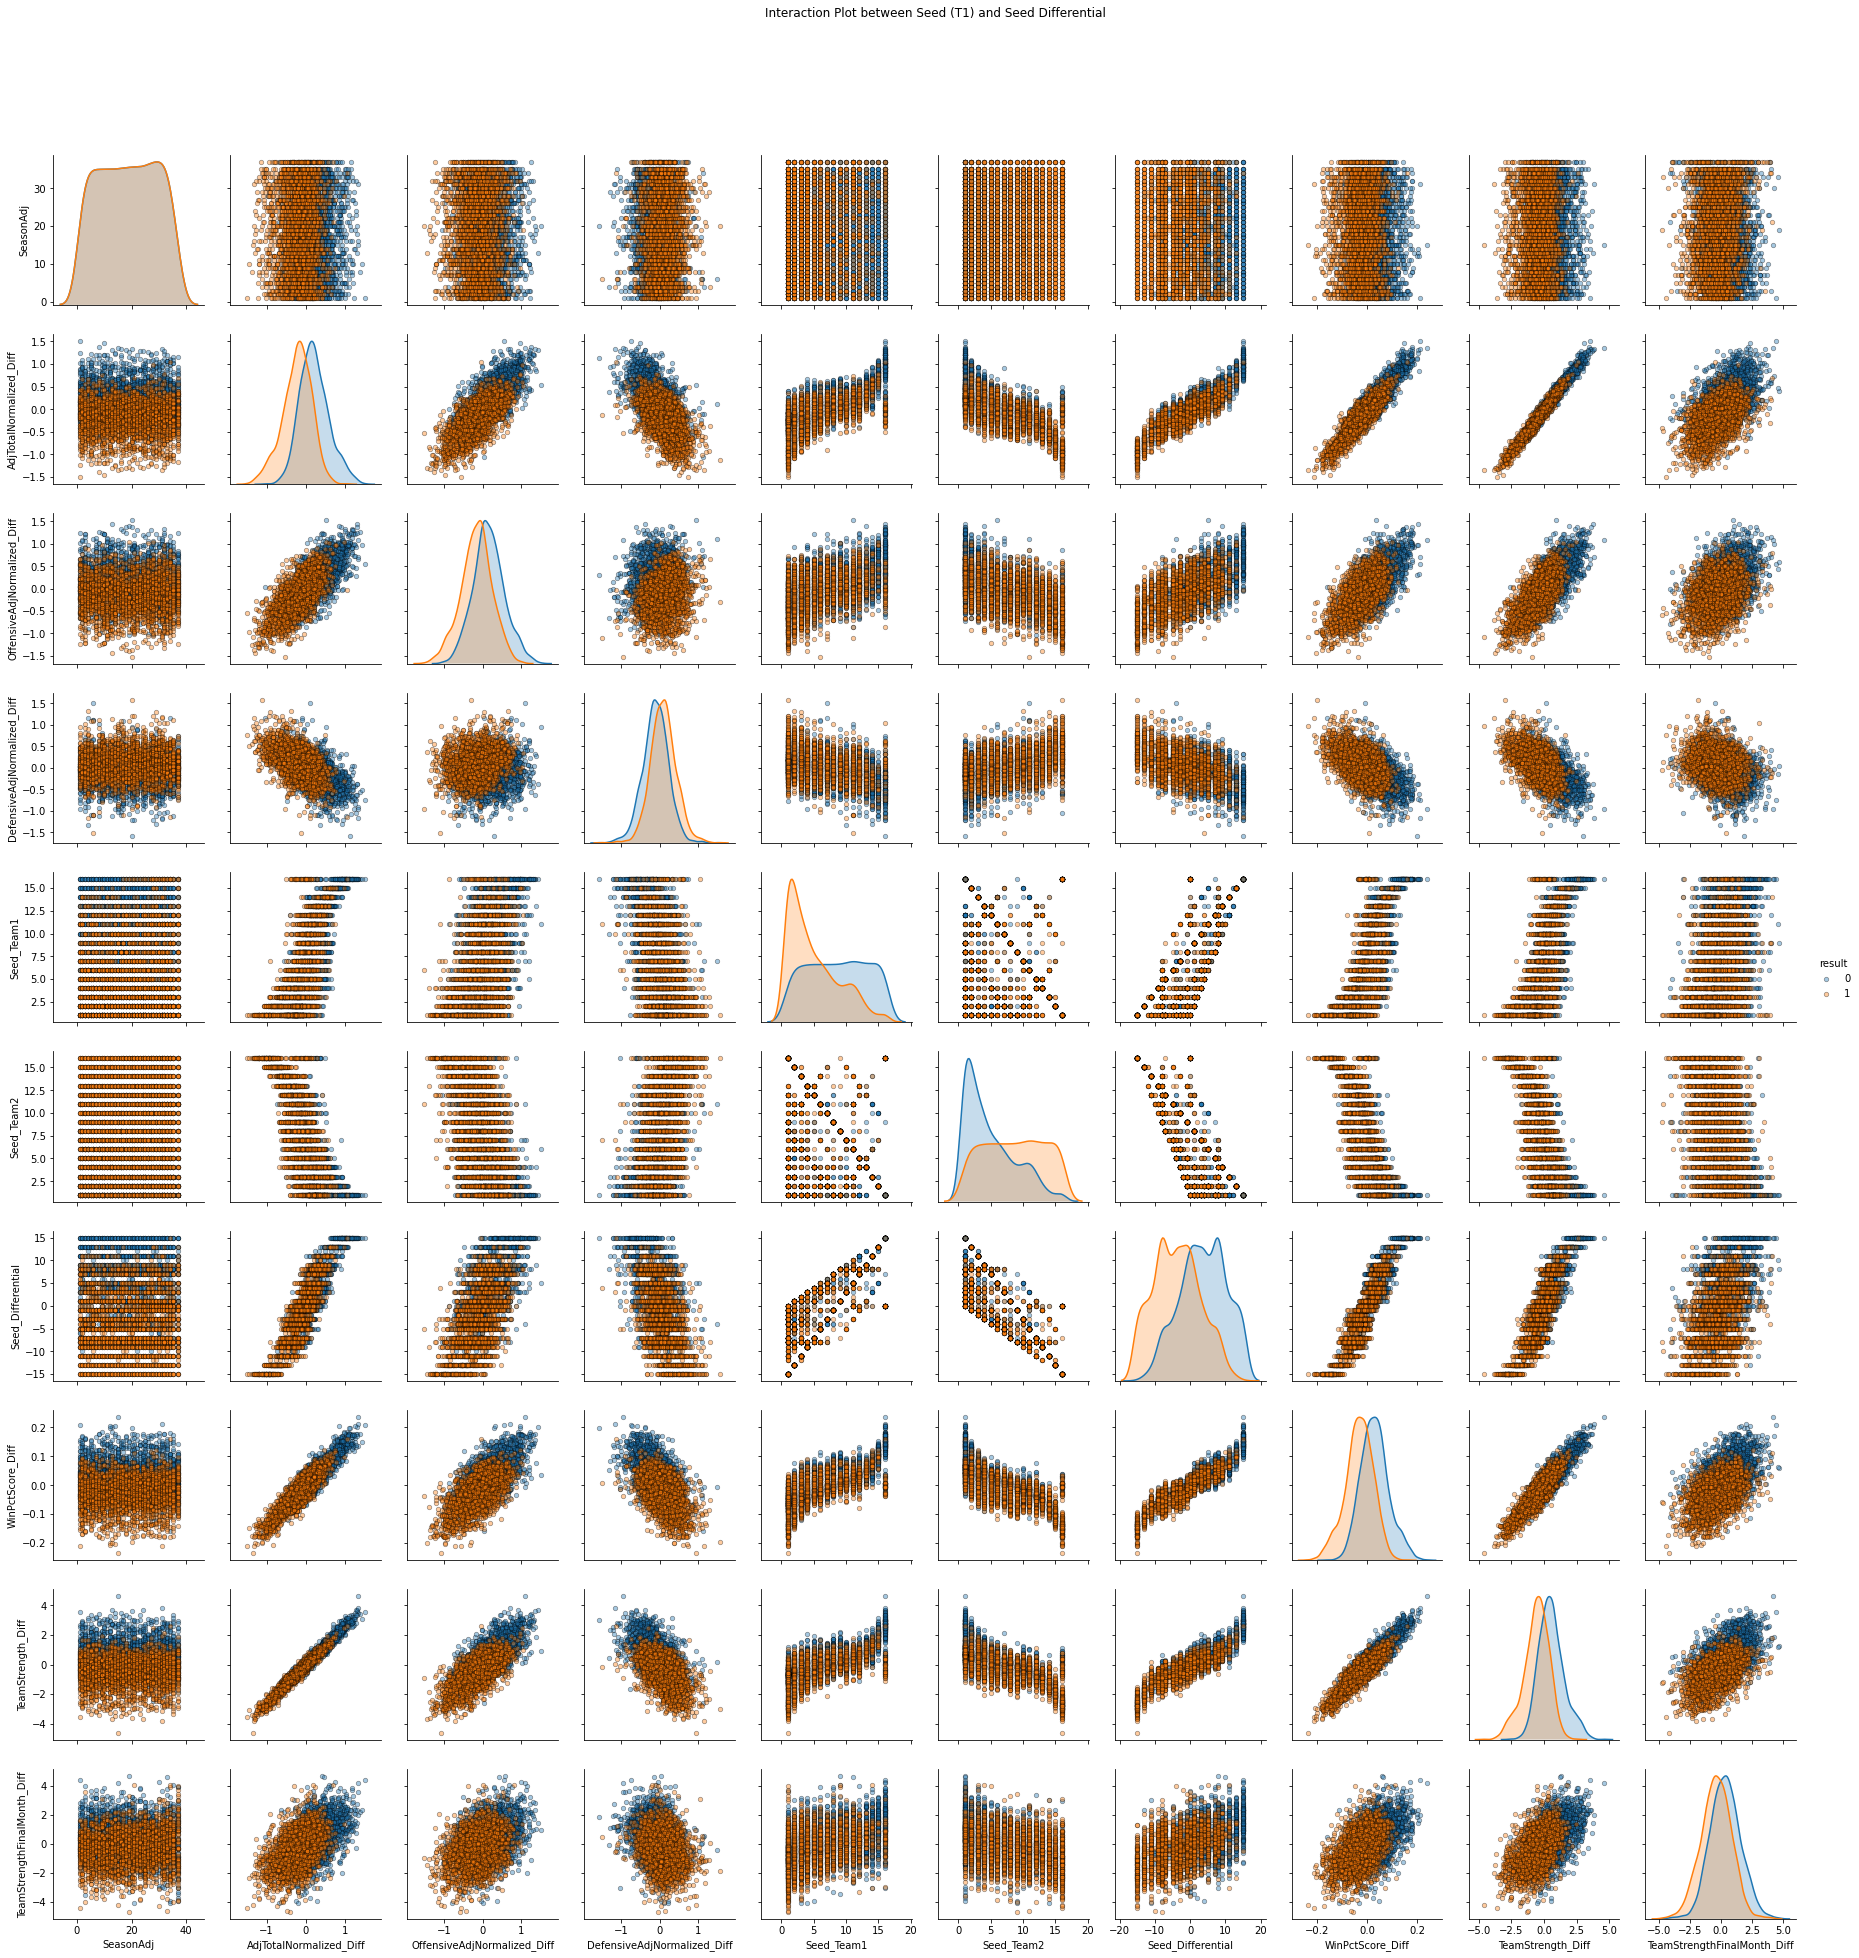

In [326]:
plot = sns.pairplot(explore_df_seed, hue="result", vars=feature_list, plot_kws = {'alpha': 0.4, 's': 20, 'edgecolor': 'k'})

plot.fig.suptitle("Interaction Plot between Seed (T1) and Seed Differential", y=1.08)
plt.show()

In [244]:
feature_list

['AdjTotalNormalized_Team2',
 'DefensiveAdjNormalized_Team2',
 'OffensiveAdjNormalized_Team2',
 'AdjTotalNormalized_Diff',
 'OffensiveAdjNormalized_Diff',
 'DefensiveAdjNormalized_Diff',
 'SeasonAdj',
 'Seed_Team1',
 'Seed_Team2',
 'Seed_Differential',
 'WinPctScore_Team1',
 'DefensiveAdjOpp_Team1',
 'OffensiveAdjOpp_Team1',
 'DefensiveAdj_Team1',
 'OffensiveAdj_Team1',
 'DefensiveAdjTotal_Team1',
 'OffensiveAdjTotal_Team1',
 'AdjTotal_Team1',
 'AdjTotalNormalized_Team1',
 'DefensiveAdjNormalized_Team1',
 'OffensiveAdjNormalized_Team1',
 'WinPctScore_Team2']

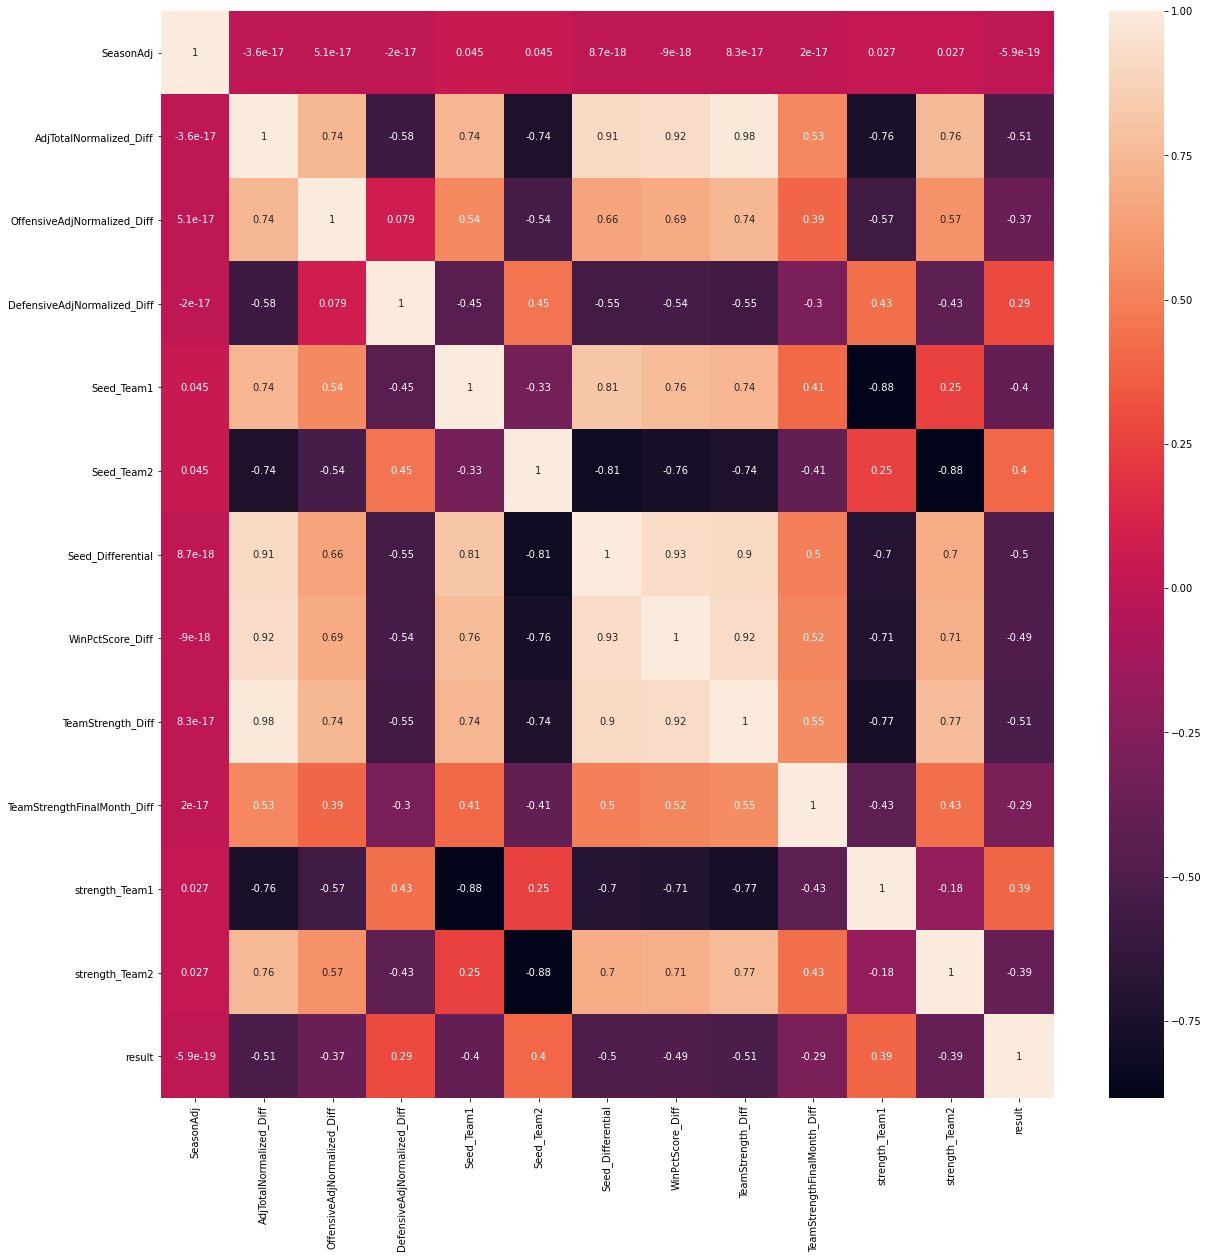

In [332]:
explore_df = explore_df_seed.drop(['Season'], axis=1)
matrix = np.triu(explore_df.corr())
fig, ax = plt.subplots(figsize=(20,20))
plot = sns.heatmap(explore_df.corr(), annot = True, ax=ax) #, mask=matrix

In [339]:
def cross_val_func(X, y, input_model, n_splits = 5, grid_search = False):
    strat_kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = np.empty(n_splits)
    y.index = X.index
    for idx, (train_idx, test_idx) in enumerate(strat_kf.split(X, y)):
        print("=" * 12 + f"Training fold {idx}" + 12 * "=")
        start = time.time()

        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        eval_set = [(X_val, y_val)]

        model = input_model
        model.fit(
            X_train,
            y_train.values.ravel(),
#             eval_set=eval_set,
#             early_stopping_rounds=400,
#             eval_metric="binary_logloss",
#             verbose=False,
        )
        
        preds = model.predict_proba(X_val)
        loss = log_loss(y_val, preds)
        scores[idx] = loss
        runtime = time.time() - start
        print(f"Fold {idx} finished with score: {loss:.5f} in {runtime:.2f} seconds.")
        if grid_search:
            print(model.best_params_)
        print('\n')
    print("=" * 12 + "Final Score" + 12 * "=")
    print(np.average(scores))
    return np.average(scores)

In [334]:
dataset = TourneySeasonData

In [372]:
x = dataset.loc[:, feature_list]
xs = pd.DataFrame(preprocessing.StandardScaler().fit_transform(x), columns = x.columns)
y = dataset[['result']]
y.index = xs.index
xs
# x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.3, stratify = TourneyCompactResults_Train['Season'])

,SeasonAdj,AdjTotalNormalized_Diff,OffensiveAdjNormalized_Diff,DefensiveAdjNormalized_Diff,Seed_Team1,Seed_Team2,Seed_Differential,WinPctScore_Diff,TeamStrength_Diff,TeamStrengthFinalMonth_Diff,strength_Team1,strength_Team2
0,-1.696310,0.661416,0.544012,-0.089359,0.463033,0.247190,0.132533,0.207675,0.702610,-0.582556,-0.500154,0.581365
1,-1.696310,0.238437,-0.080995,-0.323750,0.894719,-0.184496,0.662663,0.471740,0.204604,0.223595,-0.274163,0.040781
2,-1.696310,-3.468925,-1.270006,2.134263,-1.263711,1.973934,-1.987988,-3.288716,-3.139885,-3.438170,1.159134,-3.674055
3,-1.696310,0.028254,0.567136,0.568397,0.463033,0.247190,0.132533,-0.088611,-0.015557,-0.499503,-0.672033,-0.695980
4,-1.696310,-0.821209,-1.322504,-0.569804,-0.832025,1.542248,-1.457858,-0.687890,-0.554830,-0.496757,-0.144972,-0.999016
...,...,...,...,...,...,...,...,...,...,...,...,...
4629,1.742484,0.826959,1.509775,0.790108,-0.184496,-1.263711,0.662663,0.955287,0.798940,1.179936,0.374120,1.603920
4630,1.742484,0.828535,0.371994,-0.689480,0.894719,-1.263711,1.325325,0.971903,0.861878,0.504093,-0.275991,1.050688
4631,1.742484,0.001825,0.490184,0.633900,-1.047868,-1.263711,0.132533,0.250607,0.135438,-2.322636,0.936349,1.144828
4632,1.742484,1.449472,1.827191,0.321311,0.894719,-1.263711,1.325325,1.497886,1.221285,1.637204,-0.275991,1.603920


In [395]:
lr_params = {
    'C': [.00000001, .0001,.001,.01,.1,1,10, 100, 10000]
}

In [396]:
# lr = LogisticRegression(**lr_params)
lr_gs = GridSearchCV(LogisticRegression(max_iter=1000), lr_params)

In [397]:
cross_val_func(xs,y,lr_gs, grid_search=True)

============Training fold 0============
Fold 0 finished with score: 0.54891 in 0.67 seconds.
{'C': 1}


============Training fold 1============
Fold 1 finished with score: 0.51563 in 0.72 seconds.
{'C': 0.01}


============Training fold 2============
Fold 2 finished with score: 0.52191 in 0.70 seconds.
{'C': 0.01}


============Training fold 3============
Fold 3 finished with score: 0.55689 in 0.71 seconds.
{'C': 0.01}


============Training fold 4============
Fold 4 finished with score: 0.54062 in 0.73 seconds.
{'C': 0.1}


============Final Score============
0.5367939853948689


0.5367939853948689

In [402]:
knn_params = {
    'n_neighbors': [5,10,50,100, 200, 400]
}

In [403]:
knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params)

In [404]:
cross_val_func(xs,y,knn_gs, grid_search=True)

============Training fold 0============
Fold 0 finished with score: 0.54241 in 2.40 seconds.
{'n_neighbors': 100}


============Training fold 1============
Fold 1 finished with score: 0.55966 in 2.49 seconds.
{'n_neighbors': 200}


============Training fold 2============
Fold 2 finished with score: 0.52013 in 2.45 seconds.
{'n_neighbors': 100}


============Training fold 3============
Fold 3 finished with score: 0.53054 in 2.46 seconds.
{'n_neighbors': 200}


============Training fold 4============
Fold 4 finished with score: 0.55340 in 2.59 seconds.
{'n_neighbors': 400}


============Final Score============
0.541225960853317


0.541225960853317

In [349]:
lgb_params_gs = {
          'max_depth': [-1]
          ,'n_estimators': [1000]
          ,'learning_rate': [.001]
          ,'objective': ['binary']
          ,'num_leaves': [5, 10, 20, 40]
          ,'min_child_samples': [50, 100, 200]
    
}

In [350]:
lgbm_gs = GridSearchCV(lgb.LGBMClassifier(), lgb_params_gs)
lgbm = lgb.LGBMClassifier(**lgb_params)

In [351]:
cross_val_func(xs,y,lgbm_gs, grid_search = True)

============Training fold 0============
Fold 0 finished with score: 0.56595 in 29.36 seconds.
{'learning_rate': 0.001, 'max_depth': -1, 'min_child_samples': 200, 'n_estimators': 1000, 'num_leaves': 10, 'objective': 'binary'}


============Training fold 1============
Fold 1 finished with score: 0.57387 in 28.19 seconds.
{'learning_rate': 0.001, 'max_depth': -1, 'min_child_samples': 50, 'n_estimators': 1000, 'num_leaves': 5, 'objective': 'binary'}


============Training fold 2============
Fold 2 finished with score: 0.57390 in 28.36 seconds.
{'learning_rate': 0.001, 'max_depth': -1, 'min_child_samples': 200, 'n_estimators': 1000, 'num_leaves': 10, 'objective': 'binary'}


============Training fold 3============
Fold 3 finished with score: 0.57168 in 28.30 seconds.
{'learning_rate': 0.001, 'max_depth': -1, 'min_child_samples': 50, 'n_estimators': 1000, 'num_leaves': 5, 'objective': 'binary'}


============Training fold 4============
Fold 4 finished with score: 0.56901 in 28.77 seconds.
{'

0.5708804148031367

In [406]:
lsvc_params_gs = {
          'C': [.1,1]
          ,'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    
}

In [407]:
lsvc = SVC(random_state=42,probability=True,kernel='linear')
lsvc_gs = GridSearchCV(SVC(random_state=42,probability=True), lsvc_params_gs)

In [408]:
cross_val_func(xs,y,lsvc_gs, grid_search = True)

============Training fold 0============
Fold 0 finished with score: 0.54089 in 29.62 seconds.
{'C': 1, 'kernel': 'poly'}


============Training fold 1============
Fold 1 finished with score: 0.52983 in 29.07 seconds.
{'C': 0.1, 'kernel': 'linear'}


============Training fold 2============
Fold 2 finished with score: 0.55649 in 28.76 seconds.
{'C': 0.1, 'kernel': 'poly'}


============Training fold 3============
Fold 3 finished with score: 0.58734 in 29.45 seconds.
{'C': 1, 'kernel': 'rbf'}


============Training fold 4============
Fold 4 finished with score: 0.53479 in 29.43 seconds.
{'C': 1, 'kernel': 'linear'}


============Final Score============
0.5498685394253657


0.5498685394253657

In [222]:
lgb_params = {
          'max_depth': -1
          ,'n_estimators': 1000
          ,'learning_rate': .001
          ,'objective': 'binary'
          ,'num_leaves': 5
          ,'min_child_samples': 100
    
}

In [223]:
sgdc_params = {
          'penalty': 'l1'
          ,'alpha': .1
          ,'learning_rate': 'optimal'
          ,'tol': .001
        }

In [390]:
def test_models(dataset, feature_list):
    rf_models = {}
    lr_models = {}
    # xgb_models = {}
    scalers = {}
    clf_models = {}

    results_final = pd.DataFrame( columns=['Year'
                                           , 'Logistic Regression'
                                           , 'Random Forest'
                                           , 'Support Vector Machine'
                                           , 'Nearest Neighbor'
                                           , 'Stacking Classifier'
                                           , 'Stochastic Gradient Descent'
                                           , 'LightGBM'])

    for i in range(2017,2022):
        if i == 2020:
            continue
        print(i)
        scaler = preprocessing.StandardScaler()

        data = dataset[dataset['Season'] >= 1985][dataset['Season'] <= i]

        scaler.fit(data)

        x_train = pd.DataFrame(scaler.transform(data[data['Season'] < i]), columns = data.columns)
        y_train = x_train[['result']].round(0)

        x_test = pd.DataFrame(scaler.transform(data[data['Season'] == i]), columns = data.columns)
        y_test = x_test[['result']].round(0)


        rf = RandomForestClassifier(n_estimators=1000)
        lr = LogisticRegression(solver='lbfgs',C=.01)
        lsvc = SVC(random_state=42,probability=True,kernel='linear')
        nnb = KNeighborsClassifier(200)
        sgd = SGDClassifier(loss = 'log', **sgdc_params)
        # xgb =  GridSearchCV(XGBClassifier(eval_metric = 'logloss'), xgb_params)
        lgbm =  lgb.LGBMClassifier(**lgb_params)

        estimators = [
            ('rf', RandomForestClassifier(n_estimators=1000)),
            ('lr',LogisticRegression(solver='lbfgs',C=.01)),
            ('nnb',KNeighborsClassifier(200)),
            ('lsvc', SVC(random_state=42,probability=True,kernel='linear')),
            ('sgd',SGDClassifier(loss = 'log', **sgdc_params)),
            ('lgb', lgb.LGBMClassifier(**lgb_params))
        #     ('xgb', RandomizedSearchCV(XGBClassifier(eval_metric = 'logloss'), xgb_params))
        ]

        clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

        model_lr = lr.fit(x_train.loc[:, feature_list], y_train.values.ravel())
        model_rf = rf.fit(x_train.loc[:, feature_list], y_train.values.ravel())
        model_lsvc = lsvc.fit(x_train.loc[:, feature_list], y_train.values.ravel())
        model_nnb = nnb.fit(x_train.loc[:, feature_list], y_train.values.ravel())
        # model_xgb = xgb.fit(x_train.loc[:, feature_list], y_train.values.ravel())
        model_clf = clf.fit(x_train.loc[:, feature_list], y_train.values.ravel())
        model_sgd = sgd.fit(x_train.loc[:, feature_list], y_train.values.ravel())
        model_lgb = lgbm.fit(x_train.loc[:, feature_list], y_train.values.ravel())

        ypred_lr = model_lr.predict_proba(x_test.loc[:, feature_list])
        ypred_rf = model_rf.predict_proba(x_test.loc[:, feature_list])
        ypred_lsvc = model_lsvc.predict_proba(x_test.loc[:, feature_list])
        ypred_nnb = model_nnb.predict_proba(x_test.loc[:, feature_list])
        # ypred_xgb = model_xgb.predict_proba(x_test.loc[:, feature_list])
        ypred_clf = model_clf.predict_proba(x_test.loc[:, feature_list])
        ypred_sgd = model_sgd.predict_proba(x_test.loc[:, feature_list])
        ypred_lgb = model_lgb.predict_proba(x_test.loc[:, feature_list])

        score_lr = log_loss(y_test, ypred_lr[:,1])
        score_rf = log_loss(y_test, ypred_rf[:,1])
        score_lsvc = log_loss(y_test, ypred_lsvc[:,1])
        score_nnb = log_loss(y_test, ypred_nnb[:,1])
        # score_xgb = log_loss(y_test, ypred_xgb[:,1])
        score_clf = log_loss(y_test, ypred_clf[:,1])
        score_sgd = log_loss(y_test, ypred_sgd[:,1])
        score_lgb = log_loss(y_test, ypred_lgb[:,1])

        lr_models[i] = model_lr 
    #     xgb_models[i] = model_xgb 
        rf_models[i] = model_rf
        scalers[i] = scaler

        clf_models[i] = model_clf

        results = pd.DataFrame([[i, score_lr, score_rf, score_lsvc, score_nnb, score_clf, score_sgd,score_lgb]], columns=
                                           ['Year'
                                           , 'Logistic Regression'
                                           , 'Random Forest'
                                           , 'Support Vector Machine'
                                           , 'Nearest Neighbor'
                                           , 'Stacking Classifier'
                                           , 'Stochastic Gradient Descent'
                                           , 'LightGBM'])

        results_final = pd.concat([results_final, results], ignore_index=True)
    results_final.set_index('Year', inplace=True)
    return results_final

In [383]:
dataset

,ID,Season,TeamID1,TeamID2,result,Seed_Team1,Seed_Team2,Seed_Differential,Season_Team1,TeamID_Team1,...,Season_Team2_Team1_TS,strength_fm_Team2,home_fm_Team2,AdjTotalNormalized_Diff,OffensiveAdjNormalized_Diff,DefensiveAdjNormalized_Diff,SeasonAdj,WinPctScore_Diff,TeamStrength_Diff,TeamStrengthFinalMonth_Diff
0,1985_1116_1234,1985,1116,1234,1,9,8,1,1985,1116,...,1985,0.961290,4.097277,0.287752,0.238710,-0.031530,1,0.013252,0.796634,-0.750413
1,1985_1120_1345,1985,1120,1345,1,11,6,5,1985,1120,...,1985,0.960079,4.097277,0.103733,-0.035540,-0.114233,1,0.030101,0.231984,0.288021
2,1985_1207_1250,1985,1207,1250,1,1,16,-15,1985,1207,...,1985,-1.644737,4.097277,-1.509170,-0.557272,0.753063,1,-0.209850,-3.560068,-4.428841
3,1985_1229_1425,1985,1229,1425,1,9,8,1,1985,1229,...,1985,0.507983,4.097277,0.012292,0.248856,0.200556,1,-0.005654,-0.017639,-0.643429
4,1985_1242_1325,1985,1242,1325,1,3,14,-11,1985,1242,...,1985,0.573717,4.097277,-0.357270,-0.580308,-0.201052,1,-0.043894,-0.629079,-0.639891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4629,2021_1425_1211,2021,1425,1211,0,6,1,5,2021,1425,...,2021,2.204950,2.401279,0.359772,0.662482,0.278785,37,0.060956,0.905856,1.519921
4630,2021_1417_1276,2021,1417,1276,1,11,1,10,2021,1417,...,2021,0.745345,2.401279,0.360457,0.163229,-0.243279,37,0.062016,0.977215,0.649342
4631,2021_1222_1124,2021,1222,1124,0,2,1,1,2021,1222,...,2021,-1.128909,2.401279,0.000794,0.215090,0.223668,37,0.015991,0.153563,-2.991877
4632,2021_1417_1211,2021,1417,1211,0,11,1,10,2021,1417,...,2021,2.204950,2.401279,0.630599,0.801762,0.113373,37,0.095579,1.384719,2.108947


In [385]:
dataset.columns

Index(['ID', 'Season', 'TeamID1', 'TeamID2', 'result', 'Seed_Team1',
       'Seed_Team2', 'Seed_Differential', 'Season_Team1', 'TeamID_Team1',
       'Score_Total_Team1', 'OScore_Total_Team1', 'Win_Team1', 'Loss_Team1',
       'NumOT_Total_Team1', 'Score_Avg_Team1', 'OScore_Avg_Team1',
       'WinPCT_Team1', 'NumOT_Avg_Team1', 'Score_Avg_Opp_Team1',
       'OScore_Avg_Opp_Team1', 'WinPCT_Opp_Team1', 'Score_Avg_Opp_Opp_Team1',
       'OScore_Avg_Opp_Opp_Team1', 'WinPCT_Opp_Opp_Team1', 'WinPctScore_Team1',
       'DefensiveAdjOpp_Team1', 'OffensiveAdjOpp_Team1', 'DefensiveAdj_Team1',
       'OffensiveAdj_Team1', 'DefensiveAdjTotal_Team1',
       'OffensiveAdjTotal_Team1', 'AdjTotal_Team1', 'AdjTotalNormalized_Team1',
       'DefensiveAdjNormalized_Team1', 'OffensiveAdjNormalized_Team1',
       'TeamID_Team1_Team1_TS', 'strength_Team1', 'home_Team1',
       'Season_Team1_Team1_TS', 'strength_fm_Team1', 'home_fm_Team1',
       'Season_Team2', 'TeamID_Team2', 'Score_Total_Team2',
       'OS

In [386]:
feature_list = [
    'SeasonAdj',
    'AdjTotalNormalized_Diff', 'OffensiveAdjNormalized_Diff',
    'DefensiveAdjNormalized_Diff','Seed_Team1',
    'Seed_Team2', 'Seed_Differential','WinPctScore_Diff',
    'TeamStrength_Diff', 'TeamStrengthFinalMonth_Diff',
     'strength_Team1', 'strength_Team2']

In [387]:
feature_list

['SeasonAdj',
 'AdjTotalNormalized_Diff',
 'OffensiveAdjNormalized_Diff',
 'DefensiveAdjNormalized_Diff',
 'Seed_Team1',
 'Seed_Team2',
 'Seed_Differential',
 'WinPctScore_Diff',
 'TeamStrength_Diff',
 'TeamStrengthFinalMonth_Diff',
 'strength_Team1',
 'strength_Team2']

In [391]:
results_final = test_models(dataset,feature_list)

2017
2018
2019
2021


In [392]:
results_transpose = results_final.T
results_transpose['Average Score'] = (results_transpose[2017] + results_transpose[2018] + results_transpose[2019] + results_transpose[2021])/4
# results_transpose['Average Score'] = (results_transpose[2015] + results_transpose[2016] + results_transpose[2017] + results_transpose[2018] + results_transpose[2019])/5
results_transpose.sort_values('Average Score')

Year,2017,2018,2019,2021,Average Score
Logistic Regression,0.502700,0.589983,0.481372,0.635317,0.552343
Random Forest,0.505125,0.579969,0.505709,0.631857,0.555665
Stacking Classifier,0.509429,0.580547,0.498441,0.635867,0.556071
Support Vector Machine,0.508699,0.593957,0.487924,0.639671,0.557562
Nearest Neighbor,0.513480,0.587154,0.524230,0.633470,0.564584
LightGBM,0.546712,0.588545,0.546734,0.615242,0.574308
Stochastic Gradient Descent,0.555044,0.599113,0.543663,0.624871,0.580673


In [221]:
results_transpose = results_final.T
results_transpose['Average Score'] = (results_transpose[2017] + results_transpose[2018] + results_transpose[2019] + results_transpose[2021])/4
# results_transpose['Average Score'] = (results_transpose[2015] + results_transpose[2016] + results_transpose[2017] + results_transpose[2018] + results_transpose[2019])/5
results_transpose.sort_values('Average Score')

Year,2017,2018,2019,2021,Average Score
Random Forest,0.500220,0.570166,0.506214,0.625362,0.550491
Logistic Regression,0.499558,0.592886,0.503221,0.645226,0.560223
Stacking Classifier,0.503064,0.588783,0.507123,0.642490,0.560365
Support Vector Machine,0.505315,0.594290,0.506968,0.645846,0.563105
Nearest Neighbor,0.512647,0.608173,0.511229,0.622099,0.563537
LightGBM,0.528391,0.577411,0.538085,0.624420,0.567077
Stochastic Gradient Descent,0.554519,0.595783,0.556700,0.622812,0.582454


In [97]:
results_transpose = results_final.T
results_transpose['Average Score'] = (results_transpose[2017] + results_transpose[2018] + results_transpose[2019] + results_transpose[2021])/4
# results_transpose['Average Score'] = (results_transpose[2015] + results_transpose[2016] + results_transpose[2017] + results_transpose[2018] + results_transpose[2019])/5
results_transpose.sort_values('Average Score')

Year,2017,2018,2019,2021,Average Score
Stacking Classifier,0.536940,0.602731,0.516897,0.638947,0.573879
Support Vector Machine,0.533322,0.606564,0.525113,0.656906,0.580476
Logistic Regression,0.533391,0.606593,0.525164,0.656873,0.580505
Stochastic Gradient Descent,0.573296,0.610289,0.569990,0.630874,0.596112
LightGBM,0.572629,0.612795,0.572877,0.631667,0.597492
Random Forest,0.533825,0.876542,0.508978,0.620770,0.635029
Nearest Neighbor,0.522503,1.081419,0.503309,0.658858,0.691522
